<a href="https://colab.research.google.com/github/xiaoshaoyc/CSCI-4962/blob/main/CSCI_4962_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Oct  8 02:49:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Task 1
I used [pytorch](https://pytorch.org/) framework.

In pytorch, tensor computation history is automaticly tracted by
`torch.autograd`, and it is enabled by default for `torch.tensor`. As a result, we just need to focus on forward propagation, which is also the network building process. The backward propagation will be calculated by the impliment of pytorch via `Tensor.backward()`.
- `torch.nn` provides almost everything relates to the neural network, including activation functions, linear layers, and loss functions. We will use `torch.nn` heavily to build our NN.
- `torch.nn.Sequential` is used to connect different layers (automaticly pass layer`i`'s output to layer`i+1`'s input).
- `torch.optim` contains all the optimizers we need to train our network.

#### Resource I used:
- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://pytorch.org/docs/stable/autograd.html
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import TensorDataset
import torch.optim as optim
from tqdm.notebook import tqdm
from torch import nn


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0,1] => [-1,1]
    #  lambda x: x.
     ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                     download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform)

# load everything to memory for speed
dataset_X, dataset_Y = zip( *(list(trainset) + list(testset)) )
dataset_X = torch.stack(dataset_X)
dataset_Y = torch.tensor(list(dataset_Y))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Task 2
The CIFAR-10 dataset contains 60000 images with a resolution of 3x32x32(RGB·W·H) in 10 classes. The dataset is balanced, with 6000 images per class. In addition, this dataset is a clean datatset.
As mentioned in previous homework, the EDA we can do for graphic input is limited since every pixel is independent.

In [ ]:
print(dataset_X.shape)

num_per_class = []
for i in range(10):
  num_per_class.append(
      len(list(filter(lambda x:x==i, dataset_Y)))
  )

print(num_per_class)

torch.Size([60000, 3, 32, 32])
[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]


torch.Size([3, 32, 32])


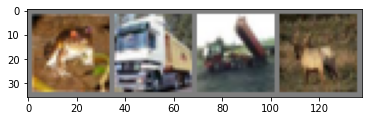

frog  truck truck deer 


In [ ]:
# Exploratory Data Analysis

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #( M, N, 3): an image with RGB values (0-1 float or 0-255 int)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = dataset_X[:4], dataset_Y[:4]
print(images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Step 2: train-dev-test split here. I followed a 70% train, 20% validation, 10% test ratio.

In [ ]:
# Perform a train-dev-test split
# 70-20-10 (train-dev-test)

dataset_XY = list(zip(dataset_X, dataset_Y))
dataset_XY = ConcatDataset([trainset, testset])
partition = np.round(np.array([0.7, 0.2, 0.1]) * len(dataset_XY)).astype(np.int32)
print(partition)
print(dataset_X.shape)

train_XY_r, dev_XY_r, test_XY_r = random_split(dataset_XY, partition)

print(f'len(train_XY) = {len(train_XY_r)}')
print(f'len(dev_XY) = {len(dev_XY_r)}')
print(f'len(test_XY) = {len(test_XY_r)}')

[42000 12000  6000]
torch.Size([60000, 3, 32, 32])
len(train_XY) = 42000
len(dev_XY) = 12000
len(test_XY) = 6000


In [ ]:
# load everything to memory for speed
gpu = torch.device('cuda:0')

# trainset
train_X, train_Y = zip( *list(train_XY_r) )
train_X = torch.stack(list(train_X)).to(gpu)
train_Y = torch.tensor(list(train_Y)).to(gpu)
train_XY = TensorDataset(
    train_X, train_Y
)

# val_dataset
dev_X, dev_Y = zip( *list(dev_XY_r) )
dev_X = torch.stack(list(dev_X)).to(gpu)
dev_Y = torch.tensor(list(dev_Y)).to(gpu)
dev_XY = TensorDataset(
    dev_X, dev_Y
)

# test_dataset
test_X, test_Y = zip( *list(test_XY_r) )
test_X = torch.stack(list(test_X)).to(gpu)
test_Y = torch.tensor(list(test_Y)).to(gpu)
test_XY = TensorDataset(
    test_X, test_Y
)

### Step 3
I used `sigmoid` as our activation function. However, I later changed to ReLU since it gives us a higher accuracy. We used every pixel as features, so we have a total of 3*32*32 features. Our hidden layer has 3000 nodes (changed to 1000 later for better performance). We also used one-hot design for our output nodes. Unlike tensorflow, pytorch define its weight delay parameters in the optimizer.

For loss function, we used `nn.CrossEntropyLoss`(with default parameters) since it is compatible with our one-hot design.

In [ ]:
# define model (forward propagation)
gpu = torch.device('cuda:0')
model = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(3*32*32, 3000),
    nn.Sigmoid(),
    nn.Linear(3000, 10),
    nn.Sigmoid()
)
model = model.to(gpu)

In [ ]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train(epoch, model, loss_fn, optim_fn, dataloader):
  pbar = tqdm(range(epoch), position=0, leave=True)
  loss_list = []
  for i in pbar:
    for sample_X, sample_Y in dataloader:
      pred_y = model(sample_X) # forward
      y = sample_Y

      optim_fn.zero_grad()
      loss = loss_fn(pred_y, y) # step4: cost
      loss_num = loss.item()
      loss_list.append(loss_num)
      pbar.set_description(f'loss={loss_num:.4}')      

      loss.backward() # backward
      optim_fn.step() # variant of GD

  return loss_list


In [ ]:
@torch.no_grad()
def validation(model, val_dataloader, loss_fn=nn.CrossEntropyLoss()):
  total_loss = []
  total_acc = []
  for sample_X, sample_Y in val_dataloader:
      pred_y = model(sample_X)
      y = sample_Y
      loss = loss_fn(pred_y, y).item()
      total_loss.append(loss)

      pred_y_label = torch.argmax(pred_y, dim=1)
      acc = ( torch.sum( (pred_y_label == y)*1 ) / len(y) ).item()
      total_acc.append(acc)
  return np.mean(total_loss), np.mean(total_acc)

  0%|          | 0/500 [00:00<?, ?it/s]

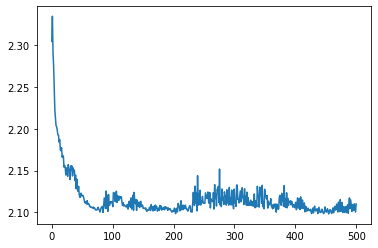

In [ ]:
train_loader = DataLoader(train_XY, batch_size=len(train_XY), shuffle=False)
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

epoch = 500
loss_list = train(epoch, model, loss_fn, optimizer, train_loader)
x_index_list = np.linspace(0, epoch, len(loss_list))
plt.plot(x_index_list, loss_list)

In [ ]:
@torch.no_grad()
def get_acc(model, dataloader):
  for sample_X, sample_Y in dataloader:
    pred_y = model(sample_X)
    pred_y = torch.argmax(pred_y, 1)
    

# model tuning

We tried different parameters and adjusted our model accordingly.

In [ ]:
# model tuning
loss_list_list = []
for i in range(1, 5):
  print(f"i={i}")
  model = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(3*32*32, i*1000),
      nn.Sigmoid(),
      nn.Linear(i*1000, 10),
      nn.Sigmoid()
  )
  model = model.to(gpu)
  optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
  loss_fn = nn.CrossEntropyLoss()

  epoch = 200
  loss_list = train(epoch, model, loss_fn, optimizer, train_loader)
  loss_list_list.append(loss_list)



i=1


  0%|          | 0/200 [00:00<?, ?it/s]

i=2


  0%|          | 0/200 [00:00<?, ?it/s]

i=3


  0%|          | 0/200 [00:00<?, ?it/s]

i=4


  0%|          | 0/200 [00:00<?, ?it/s]

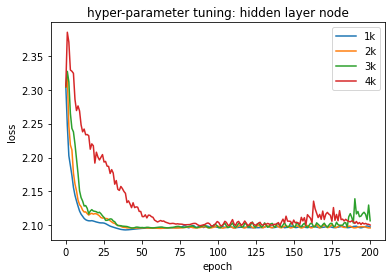

In [ ]:
for i, loss_list in enumerate(loss_list_list):
  x_index_list = np.linspace(0, epoch, len(loss_list))
  plt.plot(x_index_list, loss_list, label=f"{i+1}k")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.title(f"hyper-parameter tuning: hidden layer node")

# we choose 1k hidden nodes since it has a good performance(low loss, fast training speed, and simple)

In [ ]:
def validate_model(model):
  dev_loader = DataLoader(dev_XY, batch_size=len(dev_XY), shuffle=False)
  loss_value, acc_value = validation(model, dev_loader)
  print(f"val_loss={loss_value}, val_accuracy={acc_value}")


layers = [
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(3*32*32, 1000),
    nn.Sigmoid(),
    nn.Linear(1000, 10),
    nn.Sigmoid()
]
train_loader = DataLoader(train_XY, batch_size=len(train_XY), shuffle=False)
loss_fn = nn.CrossEntropyLoss()
epoch = 200

print("SGD")
model = nn.Sequential(*layers).to(gpu)
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.01)
loss_list1 = train(epoch, model, loss_fn, optimizer, train_loader)
validate_model(model)
print()


print("Adam")
model = nn.Sequential(*layers).to(gpu)
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
loss_list2 = train(epoch, model, loss_fn, optimizer, train_loader)
validate_model(model)
print()


print("RMSprop")
model = nn.Sequential(*layers).to(gpu)
optimizer = optim.RMSprop(model.parameters(), lr=0.003, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
loss_list3 = train(epoch, model, loss_fn, optimizer, train_loader)
validate_model(model)
print()

# Adam is better than the others.

SGD


  0%|          | 0/200 [00:00<?, ?it/s]

val_loss=2.2600910663604736, val_accuracy=0.24708333611488342

Adam


  0%|          | 0/200 [00:00<?, ?it/s]

val_loss=2.099334716796875, val_accuracy=0.3098333179950714

RMSprop


  0%|          | 0/200 [00:00<?, ?it/s]

val_loss=2.2914581298828125, val_accuracy=0.12016666680574417



Text(0.5, 1.0, 'hyper-parameter tuning: aoptimizer')

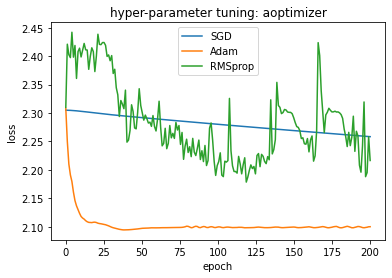

In [ ]:
x_index_list = np.linspace(0, epoch, len(loss_list))
plt.plot(x_index_list, loss_list1, label=f"SGD")
plt.plot(x_index_list, loss_list2, label=f"Adam")
plt.plot(x_index_list, loss_list3, label=f"RMSprop")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title(f"hyper-parameter tuning: optimizer")
""

3 layer model


  0%|          | 0/200 [00:00<?, ?it/s]

loss=2.3028295040130615, accuracy=0.09883332997560501


''

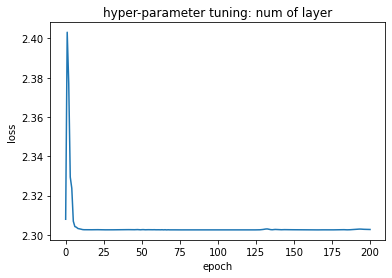

In [ ]:
print("3 layer model")
model = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(3*32*32, 3000),
      nn.Sigmoid(),
      nn.Linear(3000, 2000),
      nn.Sigmoid(),
      nn.Linear(2000, 10),
      nn.Sigmoid(),
  )
model = model.to(gpu)
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
loss_list = train(epoch, model, loss_fn, optimizer, train_loader)

# validation
dev_loader = DataLoader(dev_XY, batch_size=len(dev_XY), shuffle=False)
loss_value, acc_value = validation(model, dev_loader)
print(f"val_loss={loss_value}, val_accuracy={acc_value}")

# plot
x_index_list = np.linspace(0, epoch, len(loss_list))
plt.plot(x_index_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(f"hyper-parameter tuning: num of layer")
""

# increasing the num of layers does not help in our problem

ReLU activation


  0%|          | 0/200 [00:00<?, ?it/s]

loss=1.9905661344528198, accuracy=0.3968333303928375


''

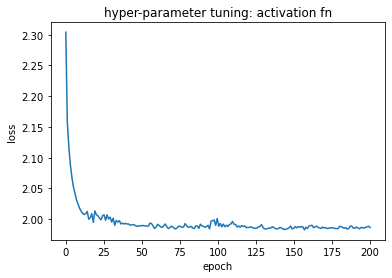

In [ ]:
print("ReLU activation")
model = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(3*32*32, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10),
      nn.Sigmoid()
  )
model = model.to(gpu)
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
loss_list = train(epoch, model, loss_fn, optimizer, train_loader)

# validation
dev_loader = DataLoader(dev_XY, batch_size=len(dev_XY), shuffle=False)
loss_value, acc_value = validation(model, dev_loader)
print(f"val_loss={loss_value}, val_accuracy={acc_value}")

# plot
x_index_list = np.linspace(0, epoch, len(loss_list))
plt.plot(x_index_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(f"hyper-parameter tuning: activation fn")
""

# increasing the num of layers does not help in our problem

Learning rate


  0%|          | 0/200 [00:00<?, ?it/s]

loss=1.9875444173812866, accuracy=0.40408334136009216


''

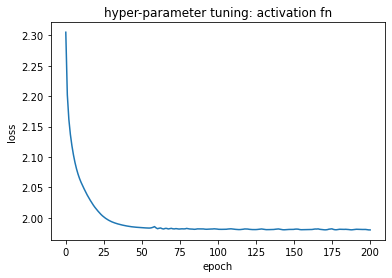

In [ ]:
print("Learning rate")
model = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(3*32*32, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10),
      nn.Sigmoid()
  )
model = model.to(gpu)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
loss_list = train(epoch, model, loss_fn, optimizer, train_loader)

# validation
dev_loader = DataLoader(dev_XY, batch_size=len(dev_XY), shuffle=False)
loss_value, acc_value = validation(model, dev_loader)
print(f"val_loss={loss_value}, val_accuracy={acc_value}")

# plot
x_index_list = np.linspace(0, epoch, len(loss_list))
plt.plot(x_index_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(f"hyper-parameter tuning: activation fn")
""

# increasing the num of layers does not help in our problem

In [ ]:
dev_loader = DataLoader(dev_XY, batch_size=len(dev_XY), shuffle=False)
validation(model, dev_loader)

(2.2268946170806885, 0.1508333384990692)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

train_X, train_Y = zip( *list(train_XY_r) )
train_X = map(lambda x:x.numpy().flatten(), train_X)
train_X_np = np.stack(list(train_X))
train_Y_np = np.array(train_Y)

dev_X, dev_Y = zip( *list(dev_XY_r) )
dev_X = map(lambda x:x.numpy().flatten(), dev_X)
dev_X_np = np.stack(list(dev_X))
dev_Y_np = np.array(dev_Y)

dt_rt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
dt_rt.fit(train_X_np, train_Y_np)
y_pred = dt_rt.predict(dev_X_np)
acc = accuracy_score(dev_Y_np, y_pred)
print(f"val_accuracy={acc}")

val_accuracy=0.4185833333333333


In [ ]:
# for our CNN model

model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),

    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
)
model = model.to(gpu)

train_loader = DataLoader(train_XY, batch_size=1000, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
loss_list = train(200, model, loss_fn, optimizer, train_loader)

# test
test_loader = DataLoader(test_XY, batch_size=len(test_XY), shuffle=False)
validation(model, test_loader)

# loss - epoch graph
x_index_list = np.linspace(0, 1000, len(loss_list))
plt.plot(x_index_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
""

  0%|          | 0/1000 [00:00<?, ?it/s]

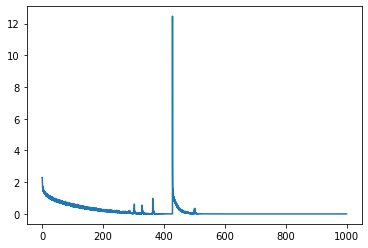

In [ ]:
x_index_list = np.linspace(0, 1000, len(loss_list))
plt.plot(x_index_list, loss_list)